# Init

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image, ImageOps
import wandb

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Consts

In [3]:
optimizers = {
    "SGD": optim.SGD,
    "Adam": optim.Adam,
    "RMSprop": optim.RMSprop
}

criterias = {
    "CrossEntropyLoss": nn.CrossEntropyLoss,
    "MSELoss": nn.MSELoss,
    "BCEWithLogits": nn.BCEWithLogitsLoss
}

## Connect to weight and biases server

In [4]:
wandb.login()

wandb: Currently logged in as: hilit (pfedhnmed). Use `wandb login --relogin` to force relogin


True

In [5]:
params = {
    'optimizer': "SGD",
    'optim.learning_rate': 0.005,
    'optim.momentum': 0.9,

    'criteria': "BCEWithLogits",

    'epochs': 1000,
    'batch_size': 32
}

wandb.init(project="Overfitting-MRI-Imaging", config=params, name="UNet-3D", entity='hilit')
config = wandb.config

wandb: Currently logged in as: hilit. Use `wandb login --relogin` to force relogin


# Load Data

In [6]:
from custom_datasets import Promise12

class OverfittingPromise12(Promise12):
    def __getitem__(self, index):
        return super().__getitem__(0)

In [7]:
dataset = OverfittingPromise12(root_dir='data', transform=transforms.ToTensor())


In [8]:
train_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=config["batch_size"],
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=config["batch_size"],
    shuffle=False)

## Explore the Data

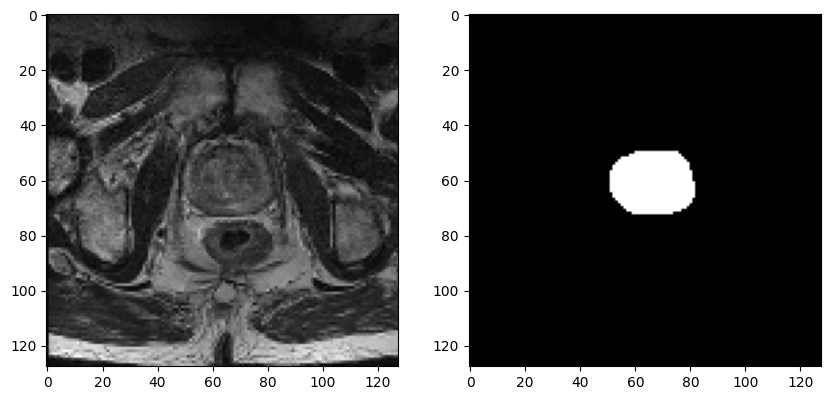

In [9]:
scan_id = 1
slice_id = 8
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(dataset[scan_id][0][slice_id, :, :], cmap='gray')
ax[1].imshow(dataset[scan_id][1][slice_id, :, :], cmap='gray')

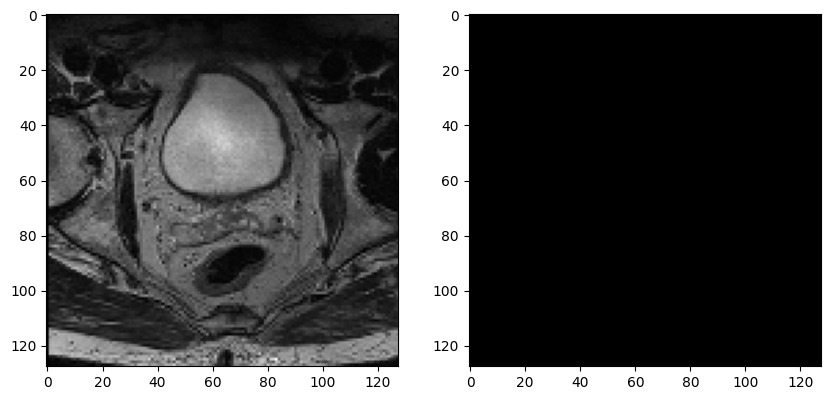

In [10]:
scan_id = 1
slice_id = 14
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(dataset[scan_id][0][slice_id, :, :], cmap='gray')
ax[1].imshow(dataset[scan_id][1][slice_id, :, :], cmap='gray')

# Define the Model

In [11]:
from models import CNNTarget
model = CNNTarget(in_channels=15, out_channels=15, features=[4, 8, 16, 32]).to(device)

In [12]:
optimizer = optimizers[config['optimizer']](model.parameters(),
                      lr=config['optim.learning_rate'],
                      momentum=config['optim.momentum'])

criteria = criterias[config['criteria']]()

In [13]:
print(model)

CNNTarget(
  (ups): ModuleList(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

# Training

In [14]:
def dice_loss_3d(pred_3d, label_3d):
    return 2 * (((pred_3d > 0.5) * (label_3d > 0.5)).sum().item() + 1) / (
            (pred_3d > 0.5).sum().item() + (label_3d > 0.5).sum().item() + 1)

def batch_dice_loss(pred, label):
    return np.mean([dice_loss_3d(pred[i], label[i]) for i in range(pred.shape[0])])

In [15]:
# Tell wandb to watch what the model gets up to: gradients, weights, and more!
# wandb.watch(model, criteria, log="all", log_freq=10)

# Run training and track with wandb
example_ct = 0  # number of examples seen
batch_ct = 0  # number of batches processed
for epoch in range(config['epochs']):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        batch_dice = batch_dice_loss(outputs.detach().numpy(), labels.detach().numpy())
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()
        example_ct += len(images)
        batch_ct += 1

        # Report metrics every 25th batch
        if ((batch_ct + 1) % 3) == 0:
            wandb.log({"epoch": epoch, "loss": float(loss), "dice": float(batch_dice)}, step=example_ct)
            print(f"Loss after {str(example_ct).zfill(5)} examples [Epoc: {epoch}]: {loss:.3f}")

Loss after 00008 examples [Epoc: 1]: 0.690
Loss after 00020 examples [Epoc: 4]: 0.689


KeyboardInterrupt: 

# Evaluate the model using the test set

# Save the model

In [17]:
torch.onnx.export(model, images, "model.onnx")
wandb.save("model.onnx")


/Users/mac/Documents/Master/pFedHN/experiments/pfedhn_seg/models.py:296: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape != skip_connection.shape:


['/Users/mac/Documents/Master/pFedHN/experiments/pfedhn_seg/wandb/run-20220928_232956-1pwveahd/files/model.onnx']

In [18]:
wandb.finish()

dice,█▁
epoch,▁█
loss,█▁
dice,0.02279
epoch,4
loss,0.68895
